# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Для обучения модели предоставляется набор фотографий людей с указанием возраста.

<b> План работы:

1. Исследовательский анализ данных: 
- загрузка данных; 
- статистический анализ возраста; 
- анализ изображений;
2. Обучение модели: 
- построение модели нейронной сети;
- обучение модели и оценка качества прогноза на тестовой выборке;
3. Анализ обученной модели

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
features, target = next(train_gen_flow)

print(features.shape) 
print(len(train_gen_flow))

(32, 224, 224, 3)
238


<AxesSubplot:>

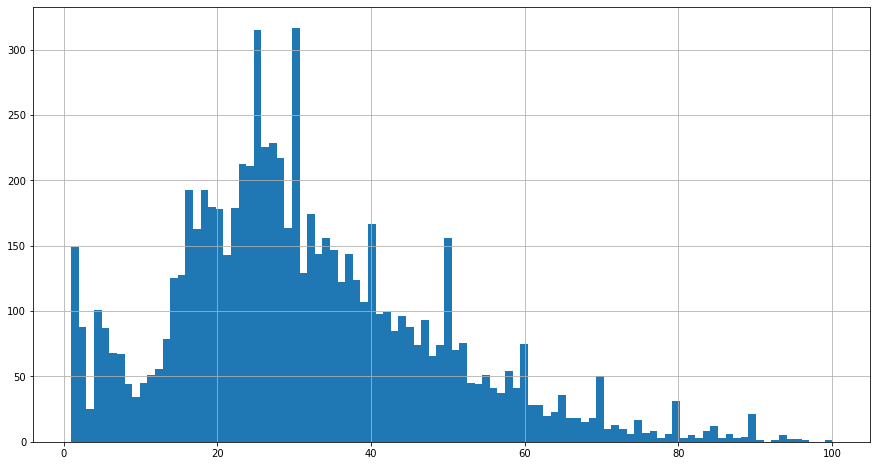

In [4]:
labels['real_age'].hist(bins = 100, figsize=(15, 8))

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

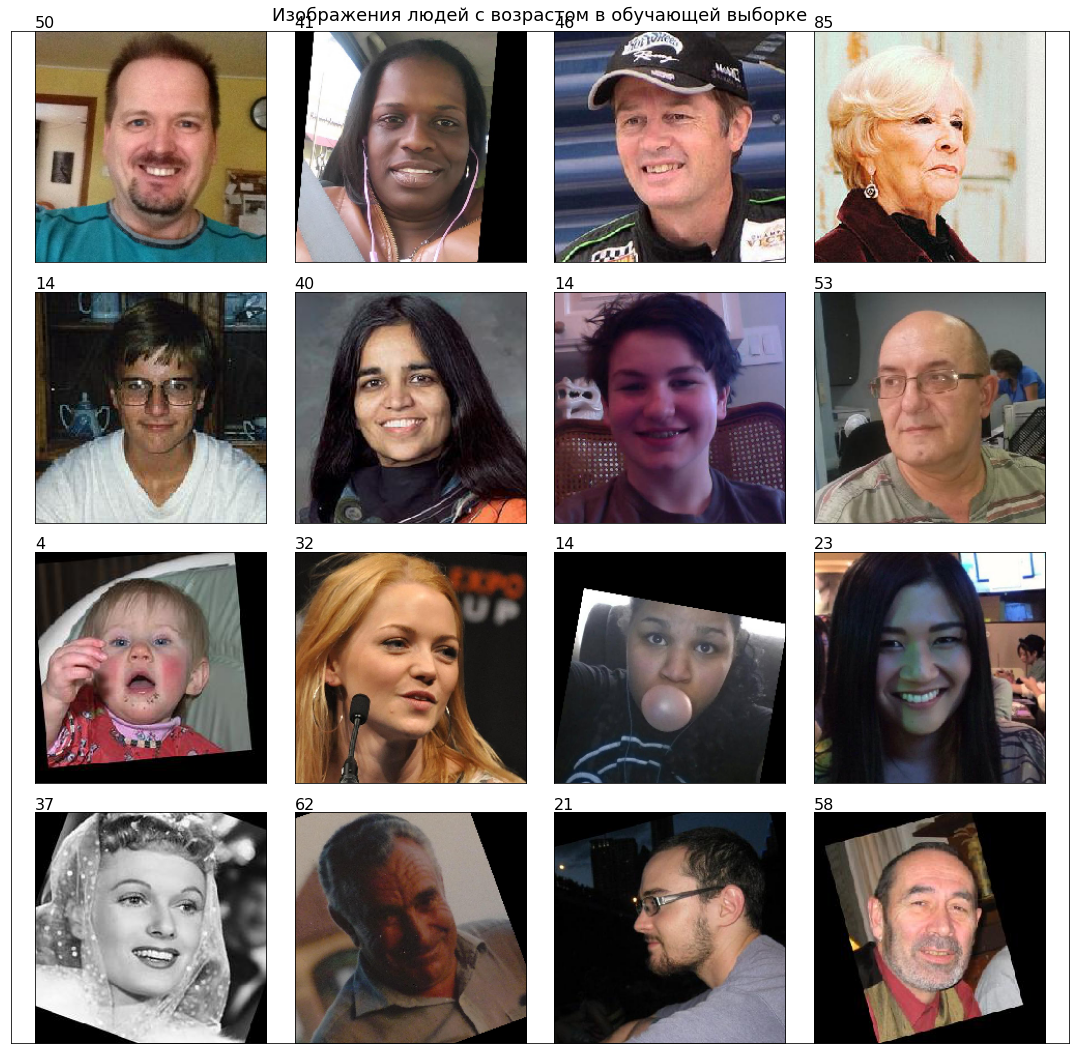

In [6]:
fig = plt.figure(figsize=(15,15))
plt.title('Изображения людей с возрастом в обучающей выборке',  verticalalignment='bottom', fontsize=18)

plt.xticks([])
plt.yticks([])
plt.tight_layout()

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i],  fontsize=16, loc = 'left', verticalalignment='top')    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
  
    

<b/> Выводы:

В исходных данных найдено 7591 RGB-изображений. При загрузке изображения разбиты на 238 батчей по 32 RGB-изображения в каждом батче. Размер выборки не очень большой, если учеть что на планете проживает около 7,753 миллиарда людей. Но если учесть внешнюю схожесть людей, то для обучения модели размер выборки достаточный. Цель - добиться приемлемого качества прогноза - получить разброс предсказания возраста в приемлемых пределах.

Размер изображения 224х224 пикселей. В исходной выборке так кроме цветных присутствуют черно-белые фотографии. Их присутствие не повлияет на процесс обучения модели. 



Распределение возраста в выборке имеет нормальное распределение со смещением влево, разброс возраста в выборке от 1 года до 100 лет. Наиболее частый возраст выборки находится в пределах от 20 лет до 41 года. Имеются отдельные выбросы, характерные для определенных возрастов, обычно это "круглый", "памятный" или юбилейный возраст. Для возраста с 1 года до 10 лет наблюдается снижение частоты, а затем увеличение частоты изображений до достижения возраста 25-30 лет, далее вновь спад. Данный график отражает реальную частоту получения фото в течение жизни. С 1 года до 10 лет жизни человека его фотографируют родители, затем он уже фотографируется все чаще самостоятельно, пик количества фотографий приходится на возраст 20-40 лет, затем человек фотографируется все реже.


Представленные в выборке изображения выявляют некоторые особенности, которые могут повлиять на качество обучения модели:

- некоторые лица представлены в профиль;

- могут присутствовать дополнительные элементы, закрывающие часть лица (жевательная резинка, очки, рука, кепка, наушники и т.д.);

- на заднем плане некоторых изображений присутствуют люди, либо элементы, схожие с лицом человека.

В качестве аугментации предполагается использоваться только отражение по горизонтали, поскольку

- аугментация с помощью поворота уже не требуется, так как часть изображений уже имеет поворот;

- вертикальное отражение не требуется, поскольку в дальнейшем модели не будут предъявляться для распознавания лица, перевернутые относительно вертикали (мы не ходим вверх ногами);

- изменение яркости и контрастности, а также сжатия и растяжения не требуется, так как предъявляться модели для распознавания модели будут реальные лица, достаточно будет сделать фото в приемлемом качестве (при хорошем освещении).



## Обучение модели

В качестве модели выбрана следующая последовательность:

1. слой: Resnet50 с инициализацией весов ImageNet. Поскольку изображений достаточно много, то замораживать данную сеть не будем.

2. слой: GlobalAveragePooling2D;

3. слой: полносвязанный слой Dense с 1 нейроном и функцией активации relu.

Для оптимизации модели будет использоваться алгоритм Adam с шагом 0.0001, в качестве метрики выбрана MAE.

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

import numpy as np
import pandas as pd
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25, horizontal_flip=True)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            subset='training',
            class_mode='raw',
            seed=12345) 
    return (test_gen_flow)

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            subset='validation',
            class_mode='raw',
            seed=12345) 
    return (test_gen_flow)
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
              metrics=['mae']) 
 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-07-08 06:43:20.038418: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-08 06:43:20.330849: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 248.3107 - mae: 11.2301 - val_loss: 559.5978 - val_mae: 18.6071
Epoch 2/10
178/178 - 37s - loss: 77.1687 - mae: 6.6108 - val_loss: 781.2008 - val_mae: 23.0639
Epoch 3/10
178/178 - 38s - loss: 51.4434 - mae: 5.4384 - val_loss: 322.9404 - val_mae: 13.1471
Epoch 4/10
178/178 - 37s - loss: 35.3372 - mae: 4.5267 - val_loss: 137.6811 - val_mae: 9.2887
Epoch 5/10
178/178 - 37s - loss: 27.0727 - mae: 3.9506 - val_loss: 80.4656 - val_mae: 6.7873
Epoch 6/10
178/178 - 37s - loss: 20.2888 - mae: 3.4533 - val_loss: 68.4851 - val_mae: 6.0615
Epoch 7/10
178/178 - 37s - loss: 16.2672 - mae: 3.0572 - val_loss: 75.1094 - val_mae: 6.6129
Epoch 8/10
178/178 - 37s - loss: 13.8685 - mae: 2.8337 - val_loss: 62.7747 - val_mae: 5.9666
Epoch 9/10
178/178 - 37s - loss: 12.0059 - mae: 2.6461 - val_loss: 64.8216 - val_mae: 5.9395
Epoch 10/10
178/178 - 37s - loss: 10.1596 - mae: 2.4504 - val_loss: 60.7543 - val_mae: 5.8363
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 60.7543 - mae: 5.8363
Test MAE: 5.8363


```

<b/> Выводы:

В результате обучения модели на тестовой выборке получена удовлетворяющая условиям задачи MAE, равная 5.8363.

## Анализ обученной модели

Для обучения использовалась сверточная нейронная сеть, состоящая из нескольких слоев. В качестве начального слоя использовалась 50-слойная нейронная сеть с архитектурой Resnet. Данная архитектура считается улучшенной правдоподобной моделью коры головного мозга и дает хорошее качества прогноза.  Для ускорения обучения в качестве весов использовалась  инициализированная матрица весов ImageNet, полученная на классификации изображения на 1000 классов. Так как для обучения был предъявлен большой объем изображений, то "заморозке" архитектура не подвергалась. Для адаптации к нашей задаче у архитектуры Resnet была удалена верхушка, добавлен переходный слой GlobalAveragePooling2D, а затем полносвязный слой. Для полносвязного слоя был задан только 1 нейрон, так как на выходе мы должны были получить предсказанный возраст. Для активации нейрона использовалась функция "Relu", поскольку предсказание возраста - это задача регрессии. По той же причине в качестве метрики была выбрана MAE.
Для оптимизации обучения модели был использован алгоритм Adam, дающий хорошую скорость обучения модели.

Использование нейронной сети на базе архитектуры ResNet и GPU позволило получить модель, имеющую хорошую точность прогноза за относительно небольшой период времени.

Обученная модель с точностью в 5,84 года позволит с предсказывает возраст покупателей. Данная величина является приемлемой, так как категоризация возраста обычно имеет больший период. Кроме того, в обычной жизни мы со схожей погрешностью можем самостоятельно определить возраст человека по его внешности. Таким образом, построенная модель удовлетворяет условиям поставленной задачи.
